In [1]:
import requests
from bs4 import BeautifulSoup, SoupStrainer
import re
from urllib import request, parse
from copy import deepcopy
from typing import List
from dataclasses import dataclass, field
import networkx as nx
import matplotlib.cm as cm
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap as Basemap
from fa2 import ForceAtlas2
import seaborn as sns
from networkx.algorithms import community
import json
import pandas as pd
from tqdm import tqdm
from thefuzz import process
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
#import swifter
#import dask
import pycountry
import nltk
from nltk.corpus import stopwords
import wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


requests.packages.urllib3.util.connection.HAS_IPV6 = False

# Functions

In [2]:
def get_wiki_page(page):
    resp = requests.get(f'https://en.wikipedia.org/api/rest_v1/page/html/{parse.quote(page)}?redirect=false&stash=false')

    if resp.status_code == 200:
        return resp.text
    else:
        return ''

In [3]:
def remove_tags(html):
  
    # parse html content
    soup = BeautifulSoup(html, "html.parser")
  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
  
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [4]:
def populate_graph(G, Teams,criterion = None):
    for team in Teams:
        if criterion is not None:
            if team.country != criterion:
                continue
        G.add_node(team.name, data=team)
        for c in team.get_connections():
            G.add_edge(team.name, c)

In [5]:
def get_city(id):
    res = requests.get(f'https://en.soccerwiki.org/squad.php?clubid={id}')
    html = BeautifulSoup(res.text)
    return html.findAll('p', {'class': 'player-info-subtitle'})[7].text.split(': ')[-1]

In [6]:
def get_location(city,country):
    resp = requests.get(f'http://api.openweathermap.org/geo/1.0/direct?q={city},{country}&limit=5&appid=###')
    try:
        response_json = resp.json()[0]
        return response_json['lat'], response_json['lon']
    except:
        return None
    

In [7]:
def get_table(season, country, url):
    r = requests.get(url.replace('year1', str(season[0])).replace('year2', str(season[1])))
    if r.status_code == 200:
        try:
            df_league = pd.read_html(r.text)[3]
            df_league['season'] = season[0]
            df_league['country'] = country
            return df_league
        except IndexError:
            return None
    else:
        return None

In [8]:
def fit_ols(df):
    lr = LinearRegression()
    lr.fit(df.in_degree.values.reshape(-1,1), df.Placement)
    return lr

In [9]:
def get_sentiment(corpus):
    
    words = map(str.lower, corpus)
    words = [w for w in words if w not in stopwords]
    df_words = set(chosen_words_sentiment.word.values)

    valid_words = [w for w in words if w in df_words]
    if len(valid_words) > 10:
        score = np.array(list(map(sentiment_dict.get, valid_words))).mean()
        return score
    
    return np.nan

In [10]:
def get_sentiment_stats():
    plt.bar(corpuses.keys(), list(map(get_sentiment, corpuses.values())))
    plt.ylim(6, 7.5)
    plt.xticks(rotation = 90)
    plt.show()

    sentiment_df = pd.DataFrame(dict(zip(corpuses.keys(),list(map(get_sentiment, corpuses.values())))), index = [0]).T.reset_index()
    sentiment_df.columns = ["Team", "SentimentScore"]
    sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")
    sentiment_df.Team = sentiment_df.Team.str.replace(" ", "")


    df_england.Team = df_england.Team.str.replace("FC", "")
    df_england.Team = df_england.Team.str.replace(" ", "")

    df_sentiment_regression = pd.merge(sentiment_df, df_england, right_on="Team", left_on="Team")[['Team', 'SentimentScore', "Placement"]]

    sc = StandardScaler()
    data = sc.fit_transform(df_sentiment_regression[['SentimentScore', "Placement"]]).T
    X, y = data[0], data[1]
    lr_sentiment = LinearRegression()
    lr_sentiment.fit(X.reshape(-1,1), y)

    print(f'R2 = {lr_sentiment.score(X.reshape(-1,1), y)}')
    print(f'Coef = {lr_sentiment.coef_}')
    print(f'Intercept = {lr_sentiment.intercept_}')

    identity = np.linspace(-1.5,1.5, 100)
    plt.scatter(y, lr_sentiment.predict(X.reshape(-1,1)))
    plt.plot(identity,identity, color = 'red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. predicted')
    plt.show()


    plt.plot(X, lr_sentiment.predict(X.reshape(-1,1)), color = 'red', label = 'prediction')
    plt.scatter(X, y, label = 'actual')
    plt.legend()
    plt.show()

# Class

In [11]:
@dataclass
class Team:
    name: str
    country: str
    no_words: int
    words: List[str]
    connections: List = field(default_factory=list)
    
    
    def add_connection(self, name):
        self.connections.append(name)
    
    def get_connections(self):
        return self.connections
    
    def __repr__(self):
        return f'Name: {self.name}'

# Reading data

The code block below gets teamnames, Wikilinks and country of all European clubs

In [12]:
# r = requests.get('https://en.wikipedia.org/wiki/List_of_top-division_football_clubs_in_UEFA_countries')
# html = r.text
# bs = BeautifulSoup(html)
# wikitables = bs.findAll("table",{"class":"wikitable"})
# h3s = bs.findAll("h3")
# countries = {}
# idx = 0
# for h3 in h3s:
#     try:
#         name = h3.find('span').text
#         if name in ['San Marino', 'Slovakia']:
#             continue
#         countries[idx] = name
#         idx += 1
#     except:
#         continue
# countries = pd.DataFrame(countries, index=[0]).T
# countries.columns = ['Country']
# countries = countries[:-8]
# teams = {}
# idx = 0

# for table in wikitables:
#     increment = True
#     for team in table.findAll('a')[3:]:
#         try:
#             name = team['title']
#             if len(re.findall('\d+', name)) != 0:
#                 continue
#             link = team['href']
#             if teams.get(name, None) is None:
#                 teams[name] = [link, idx]
#                 increment = True
#             else:
#                 increment = False
#         except:
#             increment = False
    
#     if increment:
#         idx += 1
# df = pd.DataFrame(teams).T.reset_index()
# df.columns = ['TeamName', 'Link', 'idx']
# df = df.drop_duplicates('TeamName')
# map_idx = dict(zip(list(df.idx.unique()), [i for i in range(len(df.idx.unique()))]))
# df = pd.merge(df, countries, left_on='idx', right_index=True)
# df = df[['TeamName', 'Link', 'Country']]
# df.to_csv('teams.csv')

In [13]:
df = pd.read_csv("teams.csv")
df = df.drop(columns=["Unnamed: 0"])

In [14]:
new_links = []
for i in range(df.shape[0]):
    if ("(page does not exist)" in df.TeamName[i]):
        new_links.append("No page")
        continue
    new_links.append(df.Link[i].split("/wiki/")[1])

In [15]:
df["Link"] = new_links

## Finding connections

In [16]:
Teams = []
for idx, row in tqdm(df.iterrows()):
    name = row[0]
    country = row[2]
    html = get_wiki_page(row[1])
    html_2 = deepcopy(html)
    connections = []
    for link in BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a')):
        if link.has_attr('href'):
            if link['href'].replace('./', '') in df.Link.to_list():
                connections.append(df[df['Link'] == link['href'].replace('./', '')].TeamName.values[0])
    
    words = remove_tags(html).split()
    current_team = Team(name, country, len(words), words)
    current_team.connections = connections
    Teams.append(current_team)

672it [05:07,  2.18it/s]


## Getting the city each club is located in (Can't be run because of API key, but data provided in cell below)

In [17]:
# with open('SoccerWiki_2022-11-16 - Club Data - League Data - Stadium Data_1668583927.json', 'r') as f:
#     json_data = json.loads(f.read())
# df_clubs = pd.DataFrame(json_data['ClubData'])
# dask_df = dask.dataframe.from_pandas(df, npartitions=5)
# clubs = df_clubs['Name'].values
# dask_df['club_id'] = dask_df.apply(lambda x: process.extractOne(x.TeamName, clubs)[0], axis=1)
# dask_df = dask_df.compute()
# df_latlon = pd.merge(dask_df, df_clubs[['ID', 'Name']], left_on='club_id', right_on='Name', how='left')
# df_latlon = df_latlon.drop(columns=['club_id'])
# tqdm.pandas()
# df_latlon['City'] = df_latlon['ID'].progress_apply(get_city)
# df_latlon['Country'][df_latlon['Country'].str.lower().isin(['england', 'republic of ireland', 'scotland', 'wales'])] = 'Great Britain'
# df_latlon['iso_obj'] = df_latlon.Country.apply(pycountry.countries.search_fuzzy)
# df_latlon['iso'] = df_latlon['iso_obj'].apply(lambda x: x[0].alpha_2)
# df_latlon['location'] = df_latlon.progress_apply(lambda x: get_location(x.City, x.iso), axis = 1)
# df_latlon = df_latlon.drop(columns=['iso_obj'])
# df_latlon = df_latlon.dropna()
# df_latlon['lat'] = df_latlon.location.apply(lambda x: x[0])
# df_latlon['lon'] = df_latlon.location.apply(lambda x: x[1])
# df_latlon = df_latlon.drop(columns=['location'])

## Reading in the data collected above

In [17]:
df_team_loc = pd.read_csv("teams_w_loc.csv", index_col=[0])

# Making graph

In [18]:
G = nx.DiGraph()

Connections which are dublicates or the team itself are removed.

In [19]:
for i in range(len(Teams)):
    Teams[i].connections = list(set(Teams[i].connections))
    Teams[i].connections = [ j for j in Teams[i].connections if j!=Teams[i].name]

In [20]:
populate_graph(G, Teams)

In [21]:
len(G.nodes)

672

Removing isolated nodes and nodes that we couldnt find a location for

In [22]:
G.remove_nodes_from(list(nx.isolates(G)))
G.remove_nodes_from(list(set(G.nodes).difference(set(df_team_loc.TeamName))))

In [23]:
len(G.nodes())

455

Plotting the Graph

In [24]:
cmap = cm.get_cmap('viridis', df.shape[0] + 1)

In [25]:
countries = []
for i in G.nodes():
    countries.append(G.nodes()[i].get("data").country)

In [26]:
ord_enc = OrdinalEncoder()
c_list = ord_enc.fit_transform(np.array(countries).reshape(-1, 1))

Adding small bias to avoid circular edges

In [27]:
df_team_loc.lat = df_team_loc.lat + np.random.uniform(-0.000001,0.000001,df_team_loc.shape[0])
df_team_loc.lon = df_team_loc.lon + np.random.uniform(-0.000001,0.000001,df_team_loc.shape[0])

In [28]:
pos = df_team_loc.set_index("TeamName").apply(lambda x: [x.lat, x.lon], axis=1).to_dict()

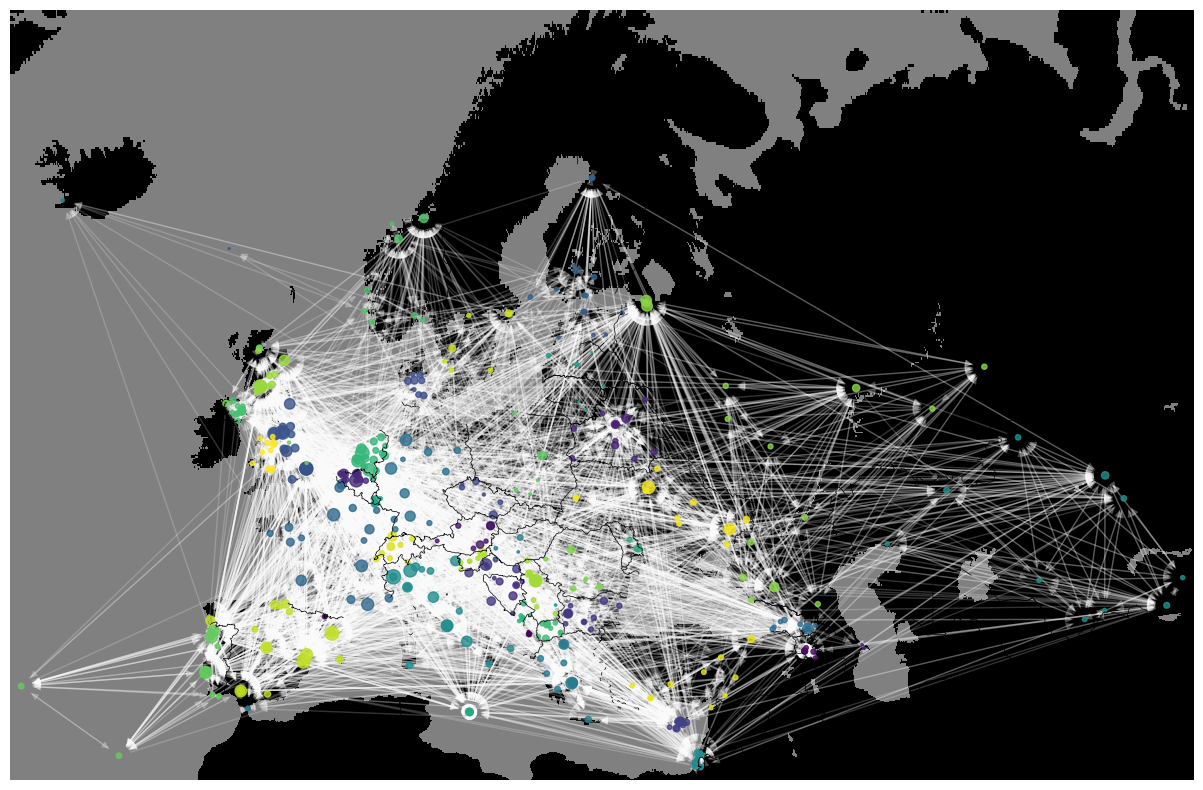

In [30]:
plt.figure(figsize=(20,10))

m = Basemap(
        projection='merc',
        llcrnrlon=df_team_loc.lon.min()-1,
        llcrnrlat=df_team_loc.lat.min()-1,
        urcrnrlon=df_team_loc.lon.max()+1,
        urcrnrlat=df_team_loc.lat.max()+1,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

mx,my=m(df_team_loc.lon,df_team_loc.lat)
df_team_loc["mx"], df_team_loc["my"] = mx, my
pos = df_team_loc.set_index("TeamName").apply(lambda x: [x.mx, x.my], axis=1).to_dict()

nx.draw_networkx_nodes(G, pos=pos, node_size=np.array(list(dict(G.in_degree()).values())), cmap=cmap, node_color=c_list, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos, edge_color="white", alpha=0.2)
plt.axis('off')

m.drawcountries()
m.drawstates()
m.drawlsmask(land_color='black',ocean_color='grey',lakes=True)

plt.show()

Plotting in- and out-degree distribution

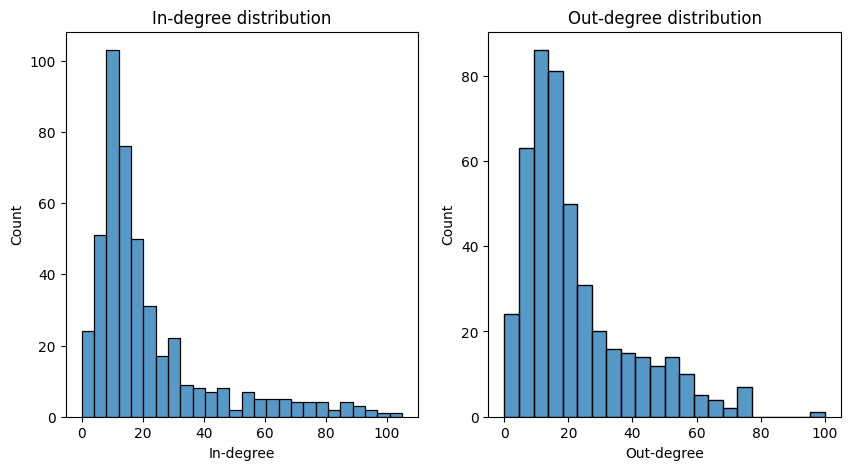

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.histplot(dict(sorted(dict(G.in_degree()).items(), key=lambda item: item[1], reverse=True)), ax=ax[0])
ax[0].set_xlabel("In-degree")
ax[0].set_title("In-degree distribution")
sns.histplot(dict(sorted(dict(G.out_degree()).items(), key=lambda item: item[1], reverse=True)), ax=ax[1])
ax[1].set_xlabel("Out-degree")
ax[1].set_title("Out-degree distribution")
plt.show()

Seeing teams in-degree

In [32]:
dict(sorted(dict(G.in_degree()).items(), key=lambda item: item[1], reverse=True))

{'Juventus F.C.': 105,
 'FC Barcelona': 97,
 'Manchester United F.C.': 95,
 'AFC Ajax': 94,
 'Valencia CF': 90,
 'R.S.C. Anderlecht': 89,
 'Chelsea F.C.': 89,
 'Liverpool F.C.': 87,
 'Rangers F.C.': 86,
 'A.C. Milan': 85,
 'Arsenal F.C.': 85,
 'Red Star Belgrade': 84,
 'Celtic F.C.': 84,
 'FC Dynamo Kyiv': 79,
 'PSV Eindhoven': 78,
 'S.L. Benfica': 77,
 'Paris Saint-Germain F.C.': 77,
 'Tottenham Hotspur F.C.': 76,
 'Olympique de Marseille': 75,
 'Villarreal CF': 74,
 'FC Porto': 74,
 'Feyenoord': 71,
 'S.S. Lazio': 71,
 'Olympique Lyonnais': 70,
 'Olympiacos F.C.': 69,
 'GNK Dinamo Zagreb': 68,
 'Sevilla FC': 68,
 'SV Werder Bremen': 68,
 'Borussia Dortmund': 66,
 'FK Partizan': 65,
 'West Ham United F.C.': 63,
 'FC Shakhtar Donetsk': 63,
 'Real Madrid CF': 63,
 'S.C. Braga': 62,
 'Aston Villa F.C.': 62,
 'Manchester City F.C.': 59,
 'PFC CSKA Moscow': 58,
 'FC Zenit Saint Petersburg': 58,
 'A.S. Roma': 57,
 'FC Dinamo Tbilisi': 57,
 'Aberdeen F.C.': 56,
 'S.S.C. Napoli': 56,
 'ACF Fi

Seeing teams out-degree

In [33]:
dict(sorted(dict(G.out_degree()).items(), key=lambda item: item[1], reverse=True))

{'Valencia CF': 100,
 'FC Dinamo Tbilisi': 77,
 'S.C. Braga': 77,
 'Sevilla FC': 75,
 'Legia Warsaw': 75,
 'GNK Dinamo Zagreb': 73,
 'AZ Alkmaar': 73,
 'Olympiacos F.C.': 73,
 'SK Slavia Prague': 71,
 'VfB Stuttgart': 70,
 'Juventus F.C.': 67,
 'AFC Ajax': 66,
 'FK Austria Wien': 66,
 'Villarreal CF': 66,
 'Feyenoord': 63,
 'FC BATE Borisov': 62,
 'FC Barcelona': 61,
 'FC Dynamo Kyiv': 60,
 'R.S.C. Anderlecht': 60,
 'Rangers F.C.': 59,
 'Paris Saint-Germain F.C.': 59,
 'RC Celta de Vigo': 59,
 'West Ham United F.C.': 58,
 'AC Omonia': 57,
 'Chelsea F.C.': 56,
 'Manchester United F.C.': 56,
 'AEK Athens F.C.': 55,
 'Real Madrid CF': 55,
 'Aston Villa F.C.': 55,
 'PFC CSKA Moscow': 54,
 'FK Partizan': 53,
 'A.C. Milan': 53,
 'Olympique de Marseille': 53,
 'SV Werder Bremen': 53,
 'Aberdeen F.C.': 52,
 'Borussia Dortmund': 52,
 'FC Porto': 52,
 'Linfield F.C.': 51,
 'FC Zenit Saint Petersburg': 51,
 'SK Sturm Graz': 51,
 'PSV Eindhoven': 51,
 'Olympique Lyonnais': 51,
 'K.V. Mechelen': 51

## Summary statistics

## Trying to plot with Force-Atlas2 layout

In [34]:
forceatlas2 = ForceAtlas2(
                    # Behavior alternatives
                    outboundAttractionDistribution=False,  # Dissuade hubs
                    linLogMode=False,  # NOT IMPLEMENTED
                    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                    edgeWeightInfluence=0.0,

                    # Performance
                    jitterTolerance=1.0,  # Tolerance
                    barnesHutOptimize=False,
                    barnesHutTheta=1.2,
                    multiThreaded=False,  # NOT IMPLEMENTED

                    # Tuning
                    scalingRatio=2.0,
                    strongGravityMode=True,
                    gravity=1.0,

                    # Log
                    verbose=True)

pos_FA = forceatlas2.forceatlas2_networkx_layout(G, pos=pos, iterations=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1064.27it/s]

Repulsion forces  took  0.66  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


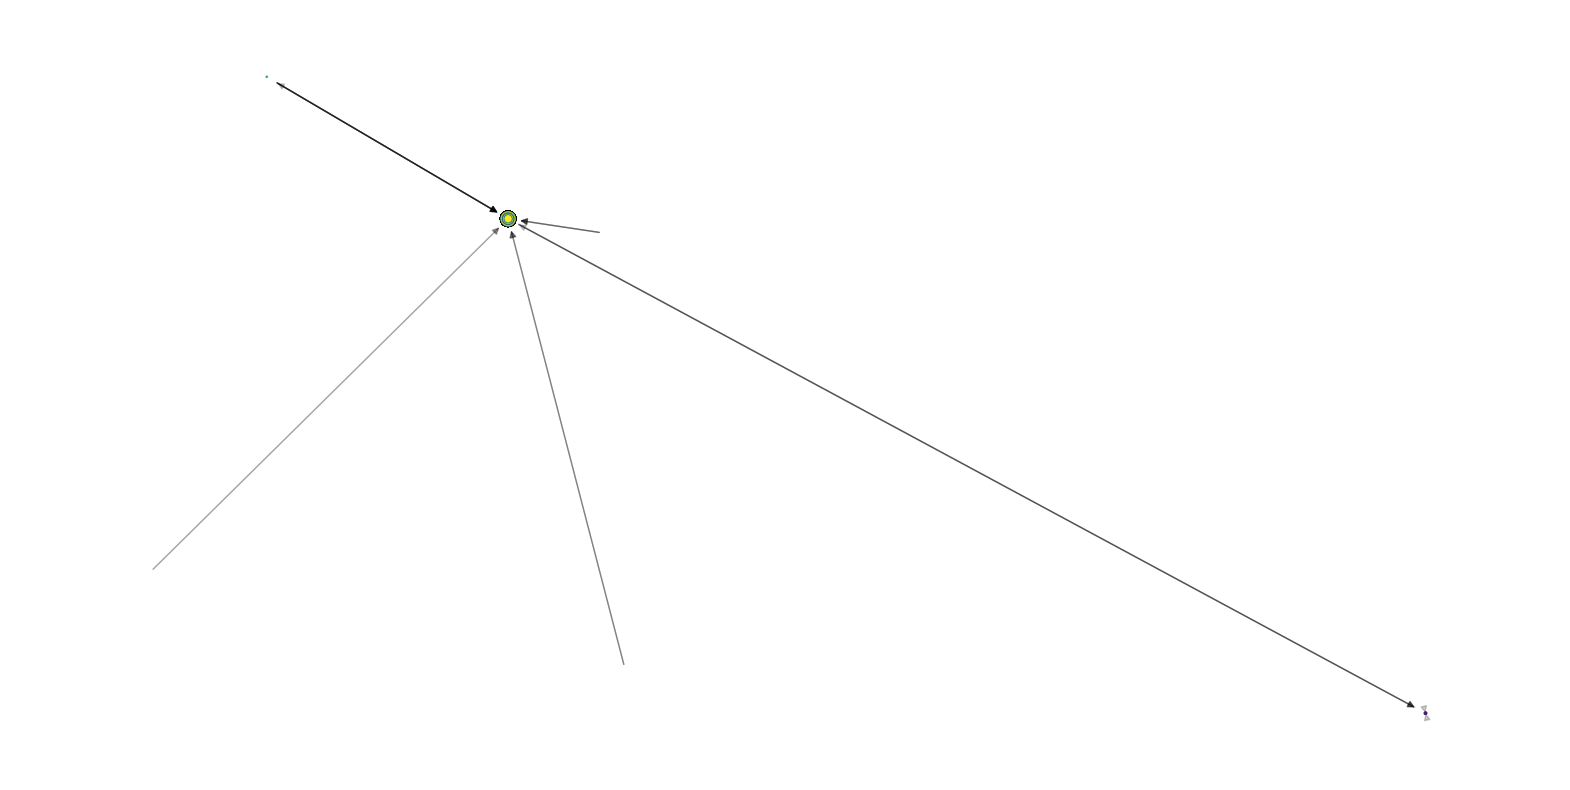

In [35]:
plt.figure(figsize=(20,10))

nx.draw_networkx_nodes(G, pos=pos_FA, node_size=np.array(list(dict(G.in_degree()).values())), cmap=cmap, node_color=c_list, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos_FA, edge_color="black", alpha=0.2)
plt.axis('off')
plt.show()

## Finding communities

In [36]:
communities = community.louvain_communities(G)

In [37]:
len(communities)

44

In [38]:
c_list_communities = []
for i in G.nodes():
    for j in range(len(communities)):
        if G.nodes()[i].get("data").name in communities[j]:
            c_list_communities.append(j+1)

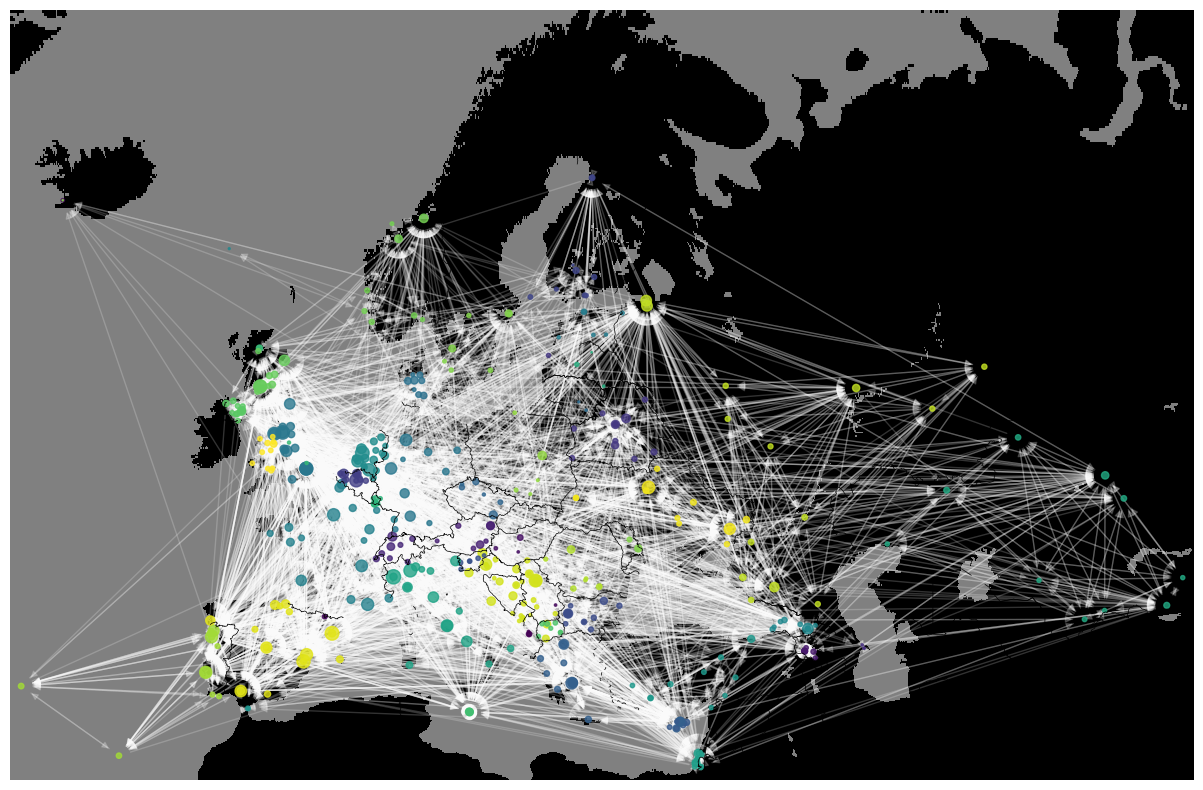

In [39]:
plt.figure(figsize=(20,10))

m = Basemap(
        projection='merc',
        llcrnrlon=df_team_loc.lon.min()-1,
        llcrnrlat=df_team_loc.lat.min()-1,
        urcrnrlon=df_team_loc.lon.max()+1,
        urcrnrlat=df_team_loc.lat.max()+1,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

mx,my=m(df_team_loc.lon,df_team_loc.lat)
df_team_loc["mx"], df_team_loc["my"] = mx, my
pos = df_team_loc.set_index("TeamName").apply(lambda x: [x.mx, x.my], axis=1).to_dict()

nx.draw_networkx_nodes(G, pos=pos, node_size=np.array(list(dict(G.in_degree()).values())), cmap=cmap, node_color=c_list_communities, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos, edge_color="white", alpha=0.2)
plt.axis('off')

m.drawcountries()
m.drawstates()
m.drawlsmask(land_color='black',ocean_color='grey',lakes=True)

plt.show()

Comparing with the normal graph plot it seems very similar

# Getting league placement for specific leagues

In [40]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/frederikms/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
seasons = [(i - 1, i) for i in range(2005, 2022)] 

In [43]:
leagues = {
        'England': 'https://www.worldfootball.net/schedule/eng-premier-league-year1-year2-spieltag/38/',
        'Italy': 'https://www.worldfootball.net/schedule/ita-serie-a-year1-year2-spieltag/38/',
        'Spain': 'https://www.worldfootball.net/schedule/esp-primera-division-year1-year2-spieltag/38/', 
        'France': 'https://www.worldfootball.net/schedule/fra-ligue-1-year1-year2-spieltag/38/'
    }

In [44]:
tables = []

for season in seasons:
    for country, url in leagues.items():
        table = get_table(season, country, url)
        if table is not None:
            tables.append(table)

In [45]:
df_league = pd.concat(tables)

In [46]:
df_league = df_league.drop(columns = 'Team').rename(columns={'#': 'Placement', 'Team.1':'Team', 'Pt.':'Points'})

In [47]:
teams_in_graph = list(G.nodes())

In [52]:
df_league['converted_team_name'] = df_league.apply(lambda x: process.extractOne(x.Team, teams_in_graph)[0], axis=1)

In [53]:
G.in_degree()[df_league.converted_team_name.iloc[0]]

89

In [54]:
df_league['in_degree'] = df_league.apply(lambda x: G.in_degree()[x['converted_team_name']], axis = 1)

In [55]:
df_league['goals_conceded'] = df_league.apply(lambda x: int(x.goals.split(':')[1]), axis=1)
df_league['goals_scored'] = df_league.apply(lambda x: int(x.goals.split(':')[0]), axis=1)

In [56]:
df_league.groupby(['country', 'Team']).agg({'goals_conceded':'mean'}).sort_values('goals_conceded', ascending = True)

goals_conceded
country Team                               
Italy   Juventus                  31.312500
Spain   FC Barcelona              32.062500
England Chelsea FC                33.705882
France  Paris Saint-Germain       33.882353
England Manchester United         34.117647
...                                     ...
Spain   CD Tenerife               74.000000
England Blackpool FC              78.000000
Italy   Benevento Calcio          79.500000
        Pescara Calcio            82.500000
England Derby County              89.000000

[161 rows x 1 columns]

In [57]:
mean_placement = df_league.groupby(['Team','country']).agg({'in_degree':'mean', 'Placement':'mean', 'Points':'mean', 'Dif.':'mean', 'goals_scored':'mean'})

In [58]:
mean_placement = mean_placement.reset_index()

# Fitting Linear Regression from in-degree

In [59]:
df_england = mean_placement[mean_placement['country'] == 'England']
df_italy = mean_placement[mean_placement['country'] == 'Italy']
df_spain = mean_placement[mean_placement['country'] == 'Spain']

In [62]:
lr_england = fit_ols(df_england)
lr_italy = fit_ols(df_italy)
lr_spain = fit_ols(df_spain)

In [63]:
variance_explained_england = round(lr_england.score(df_england.in_degree.values.reshape(-1,1), df_england.Placement),2)
variance_explained_italy = round(lr_italy.score(df_italy.in_degree.values.reshape(-1,1), df_italy.Placement),2)
variance_explained_spain = round(lr_spain.score(df_spain.in_degree.values.reshape(-1,1), df_spain.Placement),2)

## Plot

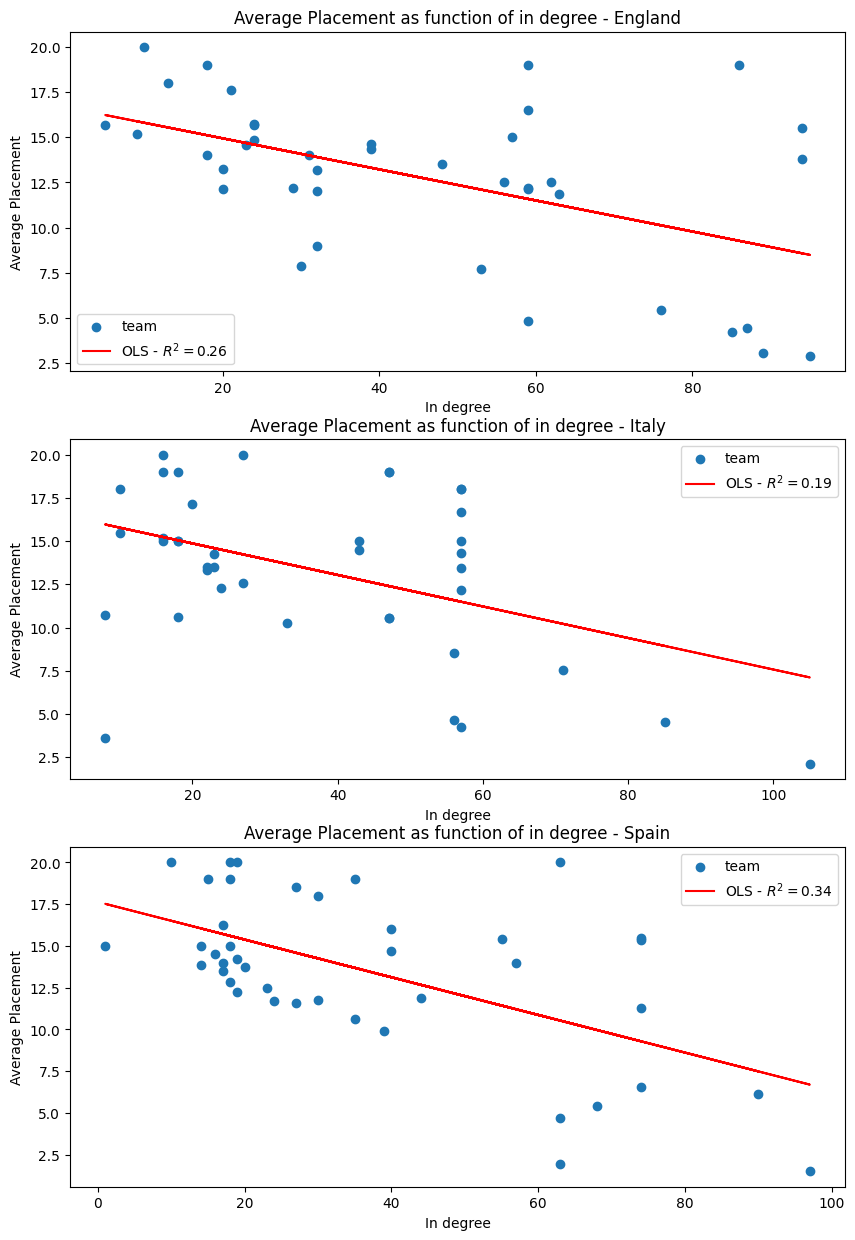

In [64]:
fig, ax = plt.subplots(3,1, figsize = (10, 15))

ax[0].scatter(df_england.in_degree, df_england.Placement, label = 'team')
ax[0].plot(df_england.in_degree, lr_england.predict(df_england.in_degree.values.reshape(-1,1)), color = 'red', label = f'OLS - $R^2 = {variance_explained_england}$')
ax[0].set_title('Average Placement as function of in degree - England')
ax[0].set_xlabel('In degree')
ax[0].set_ylabel('Average Placement')
ax[0].legend()

ax[1].scatter(df_italy.in_degree, df_italy.Placement, label = 'team')
ax[1].plot(df_italy.in_degree, lr_italy.predict(df_italy.in_degree.values.reshape(-1,1)), color = 'red', label = f'OLS - $R^2 = {variance_explained_italy}$')
ax[1].set_title('Average Placement as function of in degree - Italy')
ax[1].set_xlabel('In degree')
ax[1].set_ylabel('Average Placement')
ax[1].legend()

ax[2].scatter(df_spain.in_degree, df_spain.Placement, label = 'team')
ax[2].plot(df_spain.in_degree, lr_spain.predict(df_spain.in_degree.values.reshape(-1,1)), color = 'red', label = f'OLS - $R^2 = {variance_explained_spain}$')
ax[2].set_title('Average Placement as function of in degree - Spain')
ax[2].set_xlabel('In degree')
ax[2].set_ylabel('Average Placement')
ax[2].legend()

plt.show()

# Fitting Linear Regression as function of sentiment

In [66]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/frederikms/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
corpuses = {}

for club in G.nodes():
    club_data = G.nodes()[club].get('data')
    if club_data.country == 'England':
        corpus = [w for w in club_data.words if w not in stopwords]
        corpuses[club_data.name] = corpus

In [68]:
sentiment_words = pd.read_csv('../data/Data_Set_S1.csv')

Selecting interesting words for the purpose of predicting league placement 

In [69]:
words_of_interest  = [
    "win",
    "won",
    "champion",
    "lose",
    "loss",
    "lost",
    "concede",
    "first",
    "success",
    "successful",
    "successfully",
    "trophy",
    "trophies",
    "beaten",
    "beat",
    "lowest",
]

In [70]:
chosen_words_sentiment = sentiment_words[sentiment_words.word.isin(words_of_interest)]

In [71]:
sentiment_dict = dict(zip(chosen_words_sentiment.word, chosen_words_sentiment.happiness_average))

In [72]:
sentiment_dict['relegation'] = 2.0
sentiment_dict['relegate'] = 2.0
sentiment_dict['winless'] = 1.0
sentiment_dict['trophy'] = 7.0

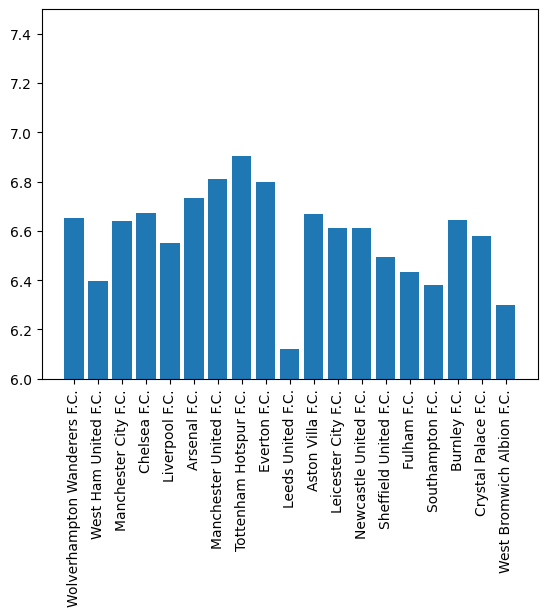

/tmp/ipykernel_1044/1517019409.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")
/tmp/ipykernel_1044/1517019409.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_england.Team = df_england.Team.str.replace("FC", "")
/tmp/ipykernel_1044/1517019409.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_england.Team = df_england.Team.str.replace(" ", "")


R2 = 0.22929515406866707
Coef = [-0.47884774]
Intercept = 3.6651162286908713e-16


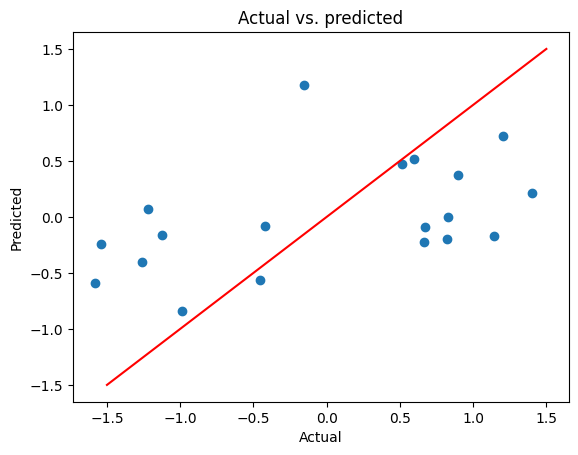

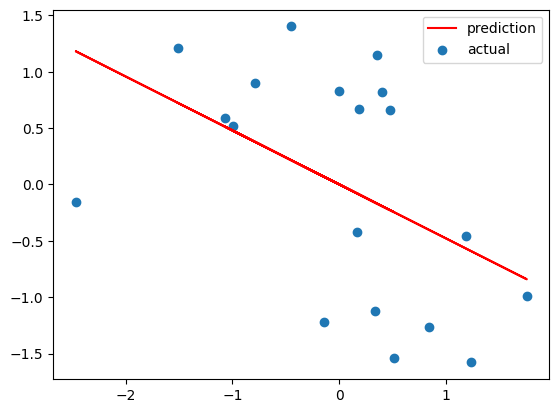

In [73]:
get_sentiment_stats()

# England specific Graph plot

In [74]:
df_england = df_team_loc[(df_team_loc.iso == "GB") & (df_team_loc.ID <= 100)]

## Plotting

/tmp/ipykernel_1044/2756456390.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_england["mx"], df_england["my"] = mx, my


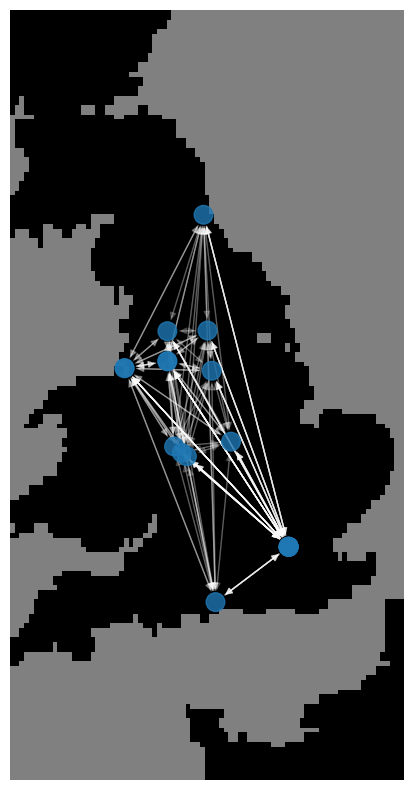

In [75]:
plt.figure(figsize=(20,10))


m = Basemap(
        projection='merc',
        llcrnrlon=df_england.lon.min()-2,
        llcrnrlat=df_england.lat.min()-2,
        urcrnrlon=df_england.lon.max()+2,
        urcrnrlat=df_england.lat.max()+2,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

mx,my=m(df_england.lon,df_england.lat)
df_england["mx"], df_england["my"] = mx, my
pos = df_england.set_index("TeamName").apply(lambda x: [x.mx, x.my], axis=1).to_dict()

nx.draw_networkx_nodes(G.subgraph(df_england.TeamName.values), pos=pos, node_size=10*np.array(list(dict(G.subgraph(df_england.TeamName.values).in_degree()).values())), alpha=0.8)
nx.draw_networkx_edges(G.subgraph(df_england.TeamName.values), pos=pos, edge_color="white", alpha=0.2)
plt.axis('off')

m.drawcountries()
m.drawstates()
m.drawlsmask(land_color='black',ocean_color='grey',lakes=True)

plt.show()

# Word cloud

In [69]:
from nltk.corpus import stopwords

In [70]:
nltk.download('stopwords')
stopwords = set(list(stopwords.words('english')) + ["club", "season", "page", "article"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/frederikms/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
def get_wordcloud(corpus, ax, country):
    tfidf = TfidfVectorizer(stop_words=stopwords)
    X = tfidf.fit_transform(corpus)
    word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
    word2tfidf=dict(sorted(word2tfidf.items(), key=lambda item: item[1]))
    wc = wordcloud.WordCloud().generate(' '.join(word2tfidf))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(country)

In [72]:
# eng_dict = {}
# for i in dict(G.nodes()).keys():
#     if G.nodes()[i].get("data").country == "England":
#         eng_dict[G.nodes()[i].get("data").name] = G.nodes()[i].get("data").words

In [73]:
league_dict = {}
league_corpus = []
for i in dict(G.nodes()).keys():
    if not league_dict.get(G.nodes()[i].get("data").country):
        league_dict[G.nodes()[i].get("data").country] = []
    league_dict.get(G.nodes()[i].get("data").country).append(G.nodes()[i].get("data").words)

In [74]:
league_df = pd.DataFrame.from_dict(league_dict, orient="index").apply(lambda x: [x[i] for i in range(19) if x[i] is not None], axis=1).reset_index()

In [75]:
league_df["corpus"] = 0 
for i in range(league_df.shape[0]):
    league_df["corpus"].iloc[i] = [' '.join(item) for item in league_df[0][i]]

/tmp/ipykernel_463/2836351621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_df["corpus"].iloc[i] = [' '.join(item) for item in league_df[0][i]]


ValueError: empty vocabulary; perhaps the documents only contain stop words

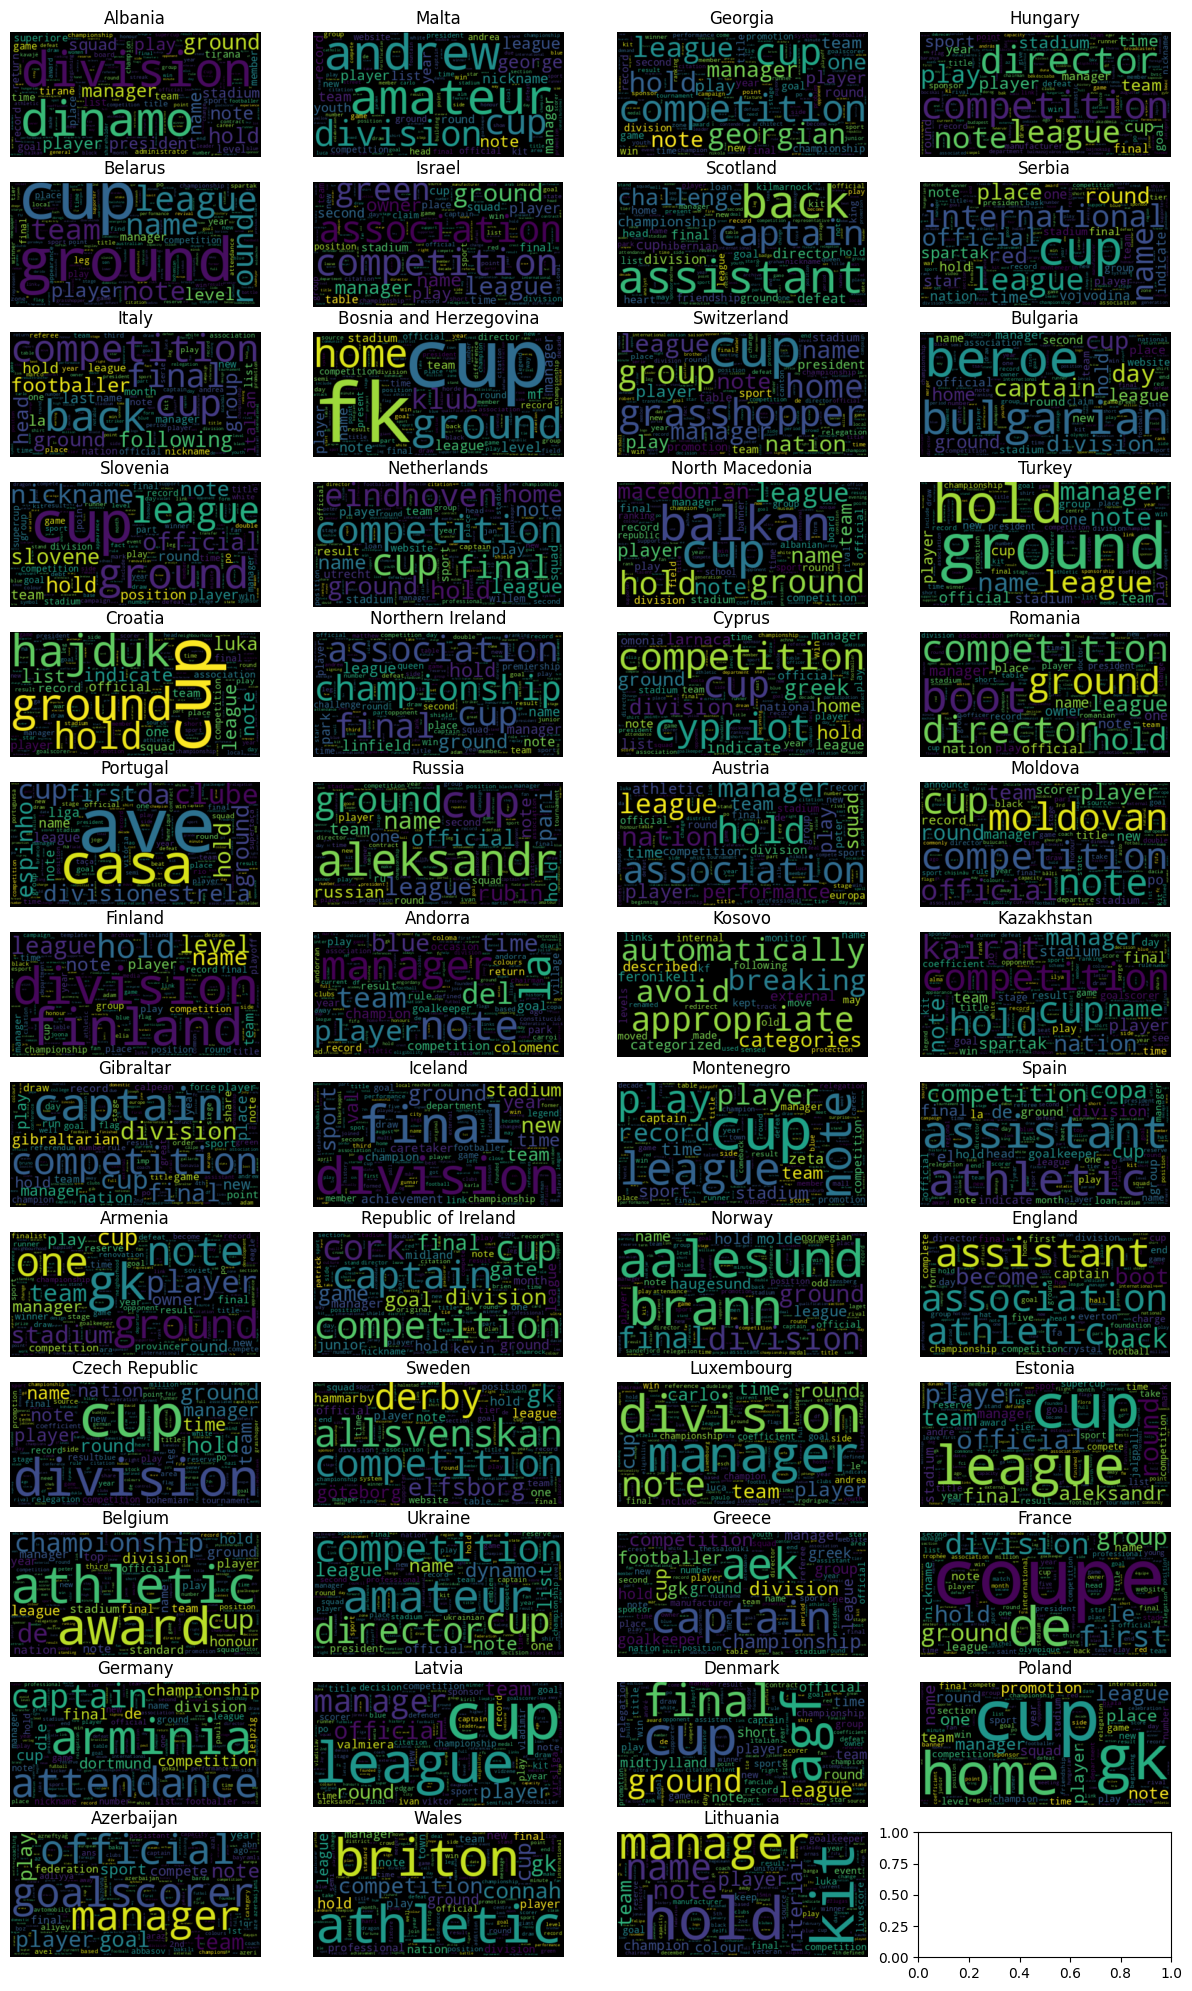

In [76]:
fig, ax = plt.subplots(13,4, figsize = (15, 25))
ax = ax.ravel()
for idx, row in league_df.iterrows():
    get_wordcloud(row["corpus"], ax[idx], row["index"])
plt.show()

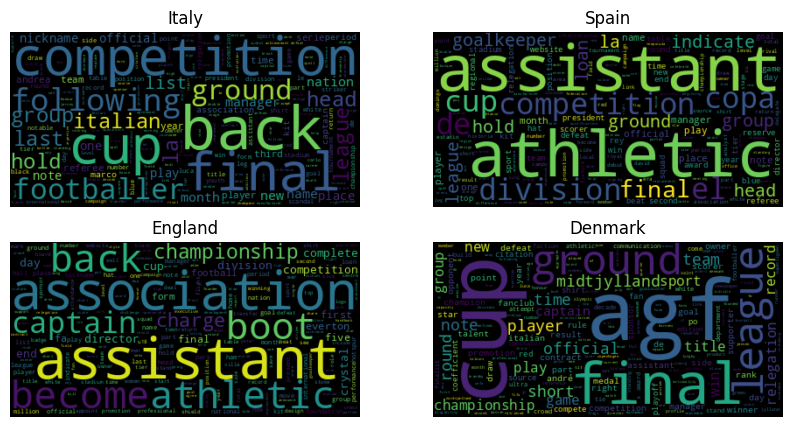

In [77]:
fig, ax = plt.subplots(2,2, figsize = (10, 5))
ax = ax.ravel()
temp_df = league_df.rename(columns= {"index":"country", "0":"0", "corpus":"corpus"})
for idx, row in temp_df[temp_df.country.isin(["England", "Italy", "Spain", "Denmark"])].reset_index().drop(columns=["index"]).iterrows():
    get_wordcloud(row["corpus"], ax[idx], row["country"])
plt.show()